In [ ]:
import copy
import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.cluster import KMeans
from collections import Counter
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

SEED = 42
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(SEED)

CONFIG = {
    'num_clients': 10,
    'client_frac': 1.0,    
    'rounds': 5,          
    'local_epochs': 2,
    'batch_size': 32,
    'lr': 0.01,
    'alphas_to_test': [0.1, 0.5, 1.0, 10.0],
    'data_subset_fraction': 0.1,
    
    'fedscam_rho_max': 0.05,
    'fedscam_summary_dim': 256,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [ ]:
def plot_client_distributions(client_loaders, num_classes=10, title=""):
    client_dist = []
    for loader in client_loaders:
        labels = []
        for _, y in loader:
            labels.extend(y.numpy())
        counts = Counter(labels)
        dist = [counts.get(i, 0) for i in range(num_classes)]
        client_dist.append(dist)
    
    client_dist = np.array(client_dist)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    bottom = np.zeros(len(client_dist))
    
    cmap = plt.get_cmap('tab10')
    
    for i in range(num_classes):
        ax.bar(range(len(client_dist)), client_dist[:, i], bottom=bottom, label=f'Class {i}', color=cmap(i))
        bottom += client_dist[:, i]
        
    ax.set_title(title)
    ax.set_xlabel('Client ID')
    ax.set_ylabel('Number of Samples')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    return client_dist

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

full_train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
full_test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

subset_indices = np.random.choice(len(full_train_dataset), int(len(full_train_dataset) * CONFIG['data_subset_fraction']), replace=False)
train_dataset = Subset(full_train_dataset, subset_indices)

def get_client_loaders(dataset, n_clients, alpha):
    targets = np.array(dataset.dataset.targets)[dataset.indices]
    
    min_size = 0
    while min_size < 10:
        idx_batch = [[] for _ in range(n_clients)]
        for k in range(10):
            idx_k = np.where(targets == k)[0]
            np.random.shuffle(idx_k)
            proportions = np.random.dirichlet(np.repeat(alpha, n_clients))
            
            proportions = np.array([p * (len(idx_j) < len(targets) / n_clients) for p, idx_j in zip(proportions, idx_batch)])
            proportions = proportions / proportions.sum()
            proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
            
            idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
            min_size = min([len(idx_j) for idx_j in idx_batch])

    client_loaders = []
    for idxs in idx_batch:
        client_subset = Subset(dataset, idxs)
        loader = DataLoader(client_subset, batch_size=CONFIG['batch_size'], shuffle=True)
        client_loaders.append(loader)
    
    return client_loaders

test_loader = DataLoader(full_test_dataset, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 53.0MB/s] 


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def create_model():
    return SimpleCNN().to(device)

In [ ]:
def get_client_labels(loader):
    labels = []
    for _, y in loader:
        labels.extend(y.numpy())
    return np.array(labels)

def flatten_params(model):
    return torch.cat([p.flatten() for p in model.parameters()])

def cosine_sim(v1, v2):
    return F.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()

def calc_entropy_score(loader, num_classes=10):
    labels = get_client_labels(loader)
    counts = Counter(labels)
    probs = np.array([counts.get(i, 0) / len(labels) for i in range(num_classes)])
    return entropy(probs + 1e-10)

def calc_kl_divergence(loader, num_classes=10):
    labels = get_client_labels(loader)
    counts = Counter(labels)
    P = np.array([counts.get(i, 0) / len(labels) for i in range(num_classes)]) + 1e-10
    P = P / P.sum()
    Q = np.ones(num_classes) / num_classes
    return entropy(P, Q)

def calc_gradient_variance(model, loader):
    model.eval()
    grads = []
    for i, (x, y) in enumerate(loader):
        if i >= 5: break
        x, y = x.to(device), y.to(device)
        model.zero_grad()
        loss = F.cross_entropy(model(x), y)
        loss.backward()
        
        batch_grads = torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None])
        grads.append(batch_grads)
    
    if not grads: return 0.0
    
    grads_stack = torch.stack(grads)
    variance = torch.var(grads_stack, dim=0).mean().item()
    return variance

def calc_cosine_heterogeneity(client_delta, global_delta):
    c_norm = torch.norm(client_delta) + 1e-10
    g_norm = torch.norm(global_delta) + 1e-10
    
    cos = torch.dot(client_delta, global_delta) / (c_norm * g_norm)
    return 1 - cos.item()

def calc_l2_score(client_delta, global_delta):
    return torch.norm(client_delta - global_delta).item()

In [ ]:
_proj_matrix = None
def get_projection_matrix(input_dim, output_dim=256):
    global _proj_matrix
    if _proj_matrix is None:
        _proj_matrix = torch.randn(output_dim, input_dim, device=device) / (output_dim ** 0.5)
    return _proj_matrix

def project(vec):
    P = get_projection_matrix(vec.shape[0], CONFIG['fedscam_summary_dim'])
    return torch.mv(P, vec)

class SAM:
    def __init__(self, params, base_optimizer, rho=0.05, **kwargs):
        self.params = list(params)
        self.base_optimizer = base_optimizer(self.params, **kwargs)
        self.rho = rho

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for p in self.params:
            if p.grad is None: continue
            e_w = (torch.pow(p.grad, 2) if 0 else p.grad) * self.rho / (grad_norm + 1e-12)
            p.add_(e_w)
            self.state[p] = e_w
        if zero_grad: self.base_optimizer.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for p in self.params:
            if p.grad is None: continue
            p.sub_(self.state[p])
        self.base_optimizer.step()
        if zero_grad: self.base_optimizer.zero_grad()
        
    def _grad_norm(self):
        stack = [p.grad.norm(p=2).to(device) for p in self.params if p.grad is not None]
        norm = torch.norm(torch.stack(stack), p=2)
        return norm
    
    def zero_grad(self):
        self.base_optimizer.zero_grad()
        self.state = {}

def train_client_fedscam(global_model, loader, epochs):
    model = copy.deepcopy(global_model)
    model.train()
    optimizer = SAM(model.parameters(), optim.SGD, rho=CONFIG['fedscam_rho_max'], lr=CONFIG['lr'])
    
    for _ in range(epochs):
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            
            optimizer.zero_grad()
            loss = F.cross_entropy(model(x), y)
            loss.backward()
            optimizer.first_step(zero_grad=True)
            
            F.cross_entropy(model(x), y).backward()
            optimizer.second_step(zero_grad=True)
            
    global_vec = flatten_params(global_model)
    local_vec = flatten_params(model)
    delta = local_vec - global_vec
    
    return delta



Running Experiment: Alpha = 0.1


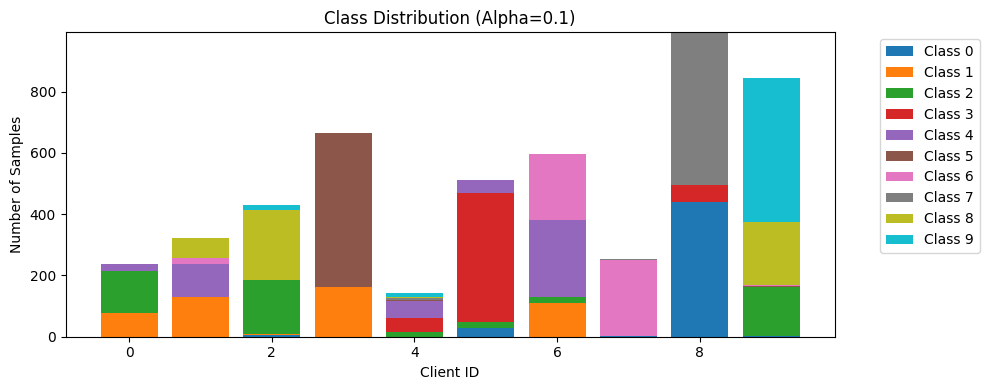

  Round 5/5...

Running Experiment: Alpha = 0.5
  Round 5/5...

Running Experiment: Alpha = 1.0
  Round 5/5...

Running Experiment: Alpha = 10.0


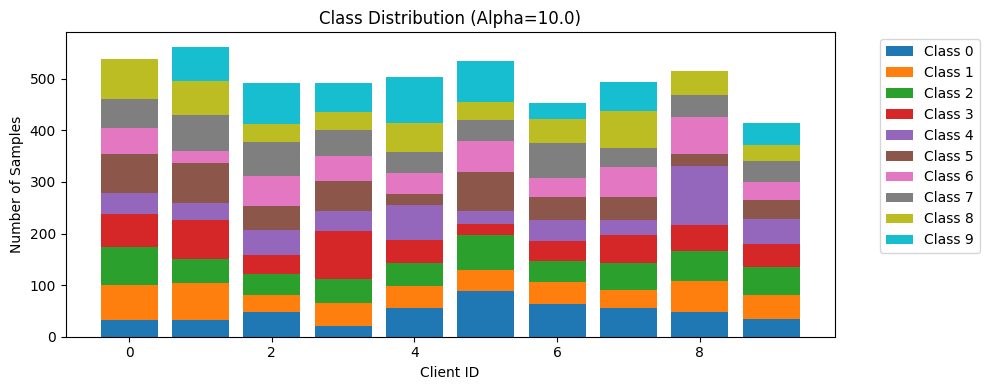

  Round 5/5...
Experiment Complete.
   alpha  round  client_id   entropy    kl_div      grad_var  cosine_het  \
0    0.1      1          0  0.921573  1.381012  1.581392e-06    0.380090   
1    0.1      1          1  1.249146  1.053439  6.845085e-07    0.445599   
2    0.1      1          2  0.920086  1.382499  9.693720e-07    0.505768   
3    0.1      1          3  0.567328  1.735257  5.698372e-07    0.671875   
4    0.1      1          4  1.451231  0.851355  7.518124e-07    0.761982   

    l2_dist  
0  0.332050  
1  0.358672  
2  0.417151  
3  0.512231  
4  0.251922  


In [ ]:
def run_heterogeneity_experiment():
    results = []
    
    for alpha in CONFIG['alphas_to_test']:
        print(f"\n\n{'='*40}")
        print(f"Running Experiment: Alpha = {alpha}")
        print(f"{'='*40}")
        
        client_loaders = get_client_loaders(train_dataset, CONFIG['num_clients'], alpha)
        
        if alpha in [0.1, 10.0]:
            plot_client_distributions(client_loaders, title=f"Class Distribution (Alpha={alpha})")
        
        global_model = create_model()
        
        entropies = [calc_entropy_score(l) for l in client_loaders]
        kl_divs = [calc_kl_divergence(l) for l in client_loaders]
        
        for round_idx in range(1, CONFIG['rounds'] + 1):
            print(f"  Round {round_idx}/{CONFIG['rounds']}...", end='\r')
            
            global_w_vec = flatten_params(global_model)
            client_deltas = []
            
            for cid in range(CONFIG['num_clients']):
                delta = train_client_fedscam(global_model, client_loaders[cid], CONFIG['local_epochs'])
                client_deltas.append(delta)
            
            global_delta = torch.stack(client_deltas).mean(dim=0)
            
            grad_vars = []
            cos_scores = []
            l2_scores = []
            
            for cid in range(CONFIG['num_clients']):
                gv = calc_gradient_variance(global_model, client_loaders[cid])
                grad_vars.append(gv)
                
                ch = calc_cosine_heterogeneity(client_deltas[cid], global_delta)
                cos_scores.append(ch)
                
                l2 = calc_l2_score(client_deltas[cid], global_delta)
                l2_scores.append(l2)
                
                results.append({
                    'alpha': alpha,
                    'round': round_idx,
                    'client_id': cid,
                    'entropy': entropies[cid],
                    'kl_div': kl_divs[cid],
                    'grad_var': gv,
                    'cosine_het': ch,
                    'l2_dist': l2
                })
            
            with torch.no_grad():
                new_params = global_w_vec + global_delta
                pointer = 0
                for p in global_model.parameters():
                    num_el = p.numel()
                    p.data.copy_(new_params[pointer:pointer+num_el].view_as(p))
                    pointer += num_el
                    
    return pd.DataFrame(results)

df_results = run_heterogeneity_experiment()
print("\nExperiment Complete.")
print(df_results.head())

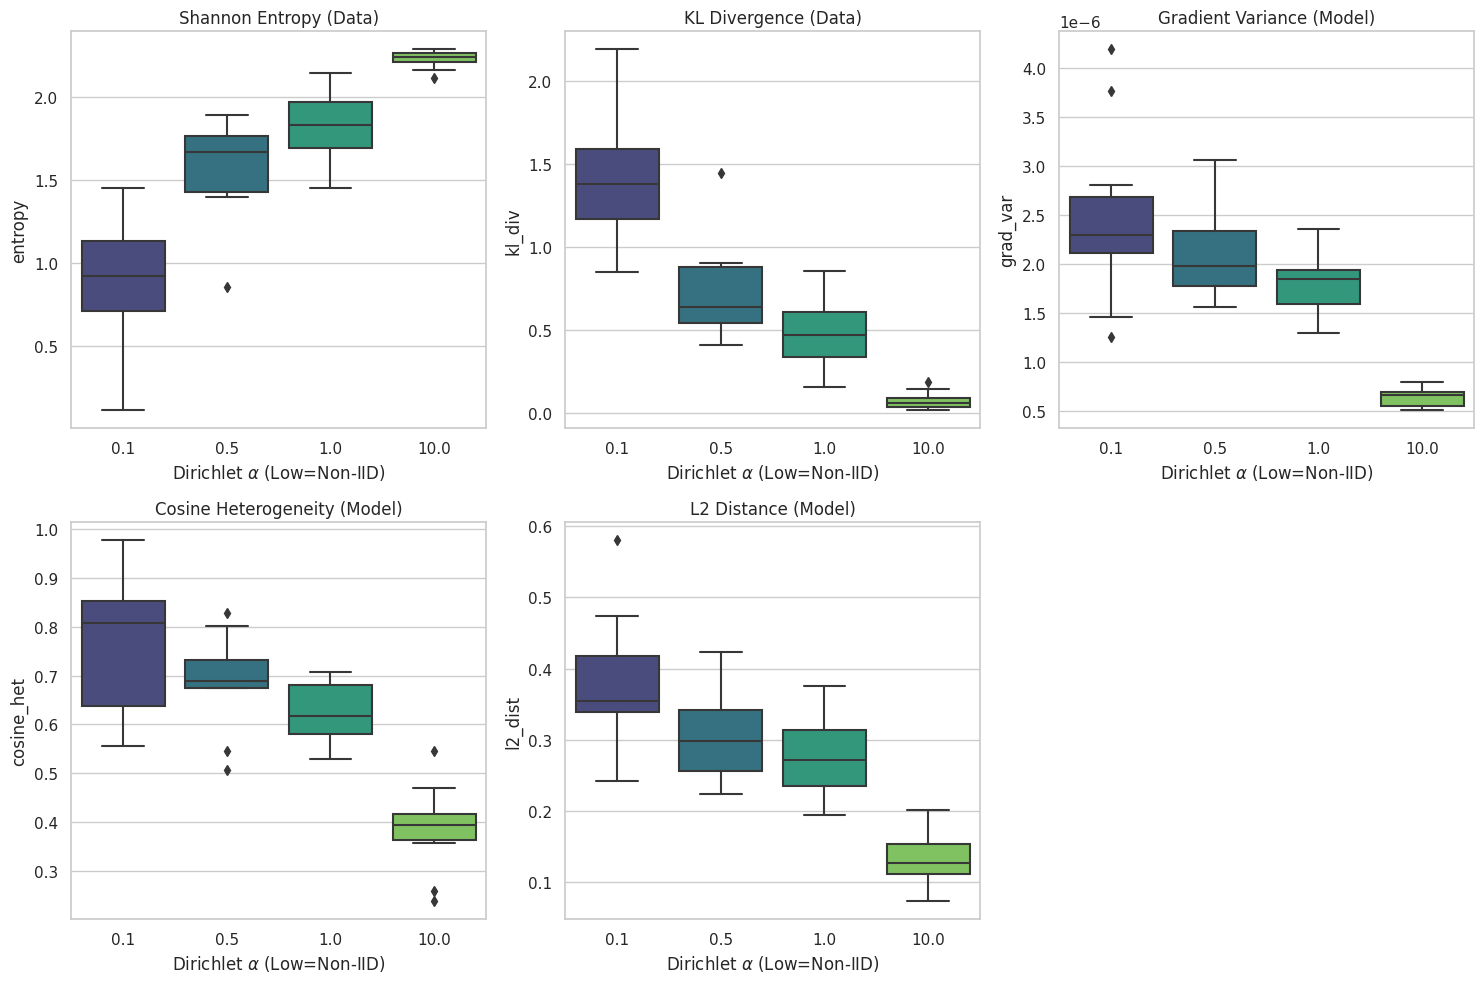

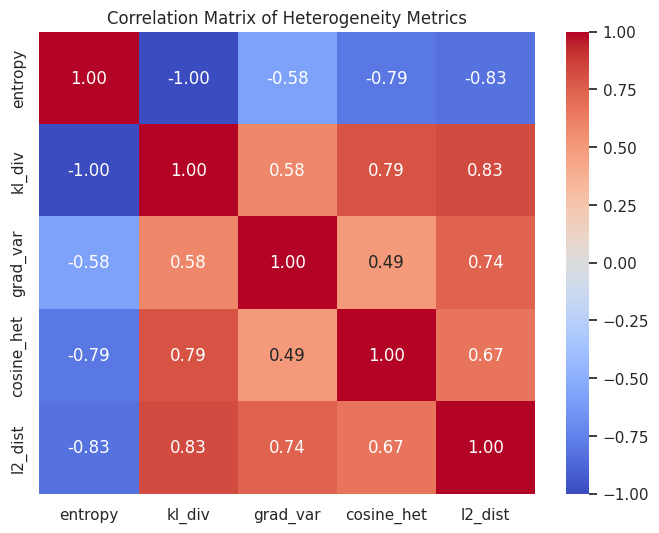

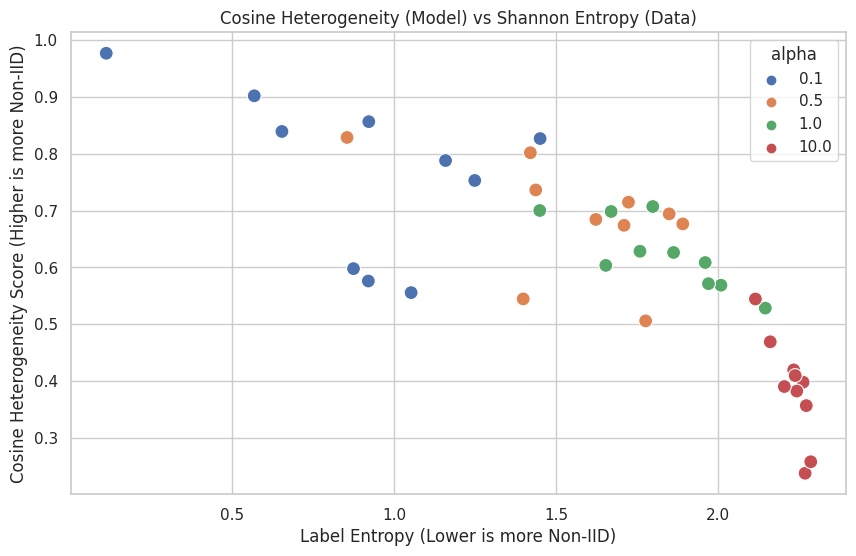

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

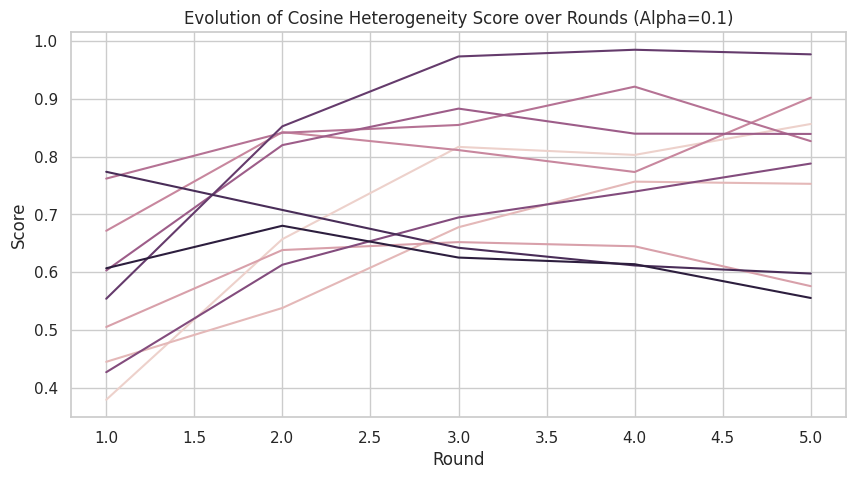

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15, 10))

metrics_to_plot = ['entropy', 'kl_div', 'grad_var', 'cosine_het', 'l2_dist']
titles = ['Shannon Entropy (Data)', 'KL Divergence (Data)', 'Gradient Variance (Model)', 'Cosine Heterogeneity (Model)', 'L2 Distance (Model)']

last_round_df = df_results[df_results['round'] == CONFIG['rounds']]

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='alpha', y=metric, data=last_round_df, palette="viridis")
    plt.title(titles[i])
    plt.xlabel(r'Dirichlet $\alpha$ (Low=Non-IID)')
    
plt.tight_layout()
plt.show()

corr_matrix = last_round_df[metrics_to_plot].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Heterogeneity Metrics")
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=last_round_df, x='entropy', y='cosine_het', hue='alpha', palette='deep', s=100)
plt.title("Cosine Heterogeneity (Model) vs Shannon Entropy (Data)")
plt.xlabel("Label Entropy (Lower is more Non-IID)")
plt.ylabel("Cosine Heterogeneity Score (Higher is more Non-IID)")
plt.show()

alpha_focus = 0.1
df_focus = df_results[df_results['alpha'] == alpha_focus]

plt.figure(figsize=(10, 5))
sns.lineplot(data=df_focus, x='round', y='cosine_het', hue='client_id', legend=False)
plt.title(f"Evolution of Cosine Heterogeneity Score over Rounds (Alpha={alpha_focus})")
plt.xlabel("Round")
plt.ylabel("Score")
plt.show()